<a href="https://colab.research.google.com/github/I-Rosenzweig/colab/blob/main/lab10_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68606236/68606236 [==============================] - 4s 0us/step
Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


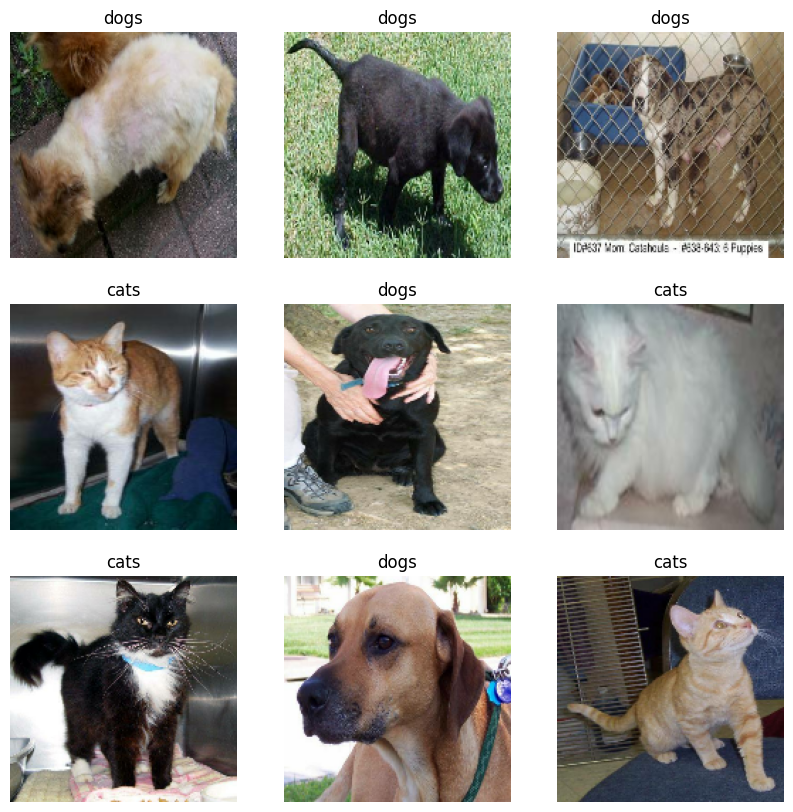

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

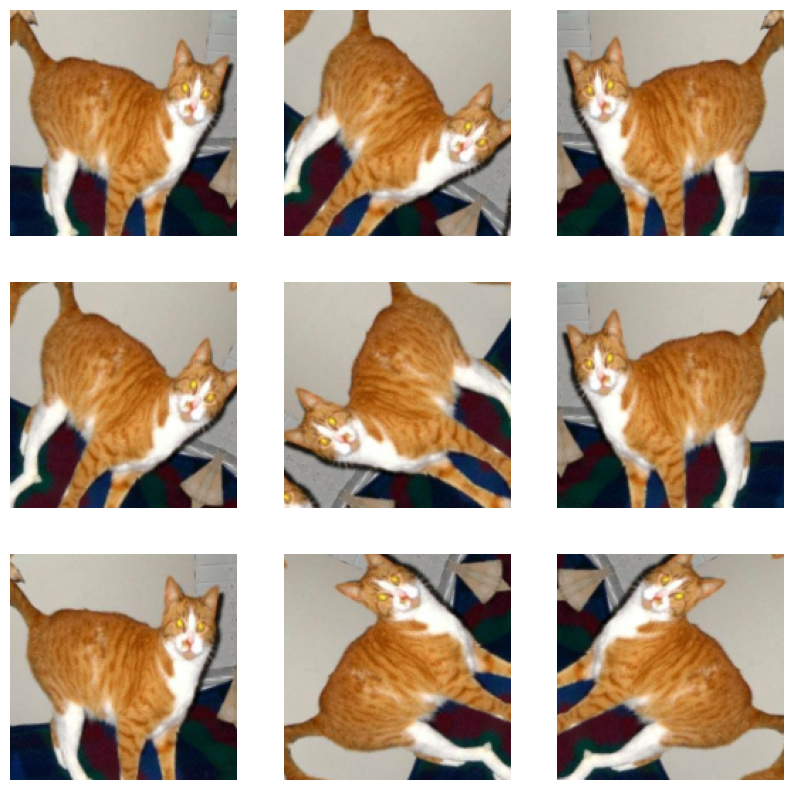

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

(32, 5, 5, 1280)
(32, 1280)
(32, 1)
26/26 [==============================] - 5s 78ms/step - loss: 0.9847 - accuracy: 0.3193
Epoch 1/10
63/63 [==============================] - 8s 63ms/step - loss: 0.8557 - accuracy: 0.4790 - val_loss: 0.6675 - val_accuracy: 0.5804
Epoch 2/10
63/63 [==============================] - 4s 57ms/step - loss: 0.6220 - accuracy: 0.6530 - val_loss: 0.4748 - val_accuracy: 0.7339
Epoch 3/10
63/63 [==============================] - 5s 66ms/step - loss: 0.5016 - accuracy: 0.7305 - val_loss: 0.3686 - val_accuracy: 0.8119
Epoch 4/10
63/63 [==============================] - 4s 55ms/step - loss: 0.4111 - accuracy: 0.7945 - val_loss: 0.2914 - val_accuracy: 0.8651
Epoch 5/10
63/63 [==============================] - 4s 55ms/step - loss: 0.3491 - accuracy: 0.8315 - val_loss: 0.2465 - val_accuracy: 0.8911
Epoch 6/10
63/63 [==============================] - 4s 57ms/step - loss: 0.3130 - accuracy: 0.8480 - val_loss: 0.2081 - val_accuracy: 0.9183
Epoch 7/10
63/63 [============

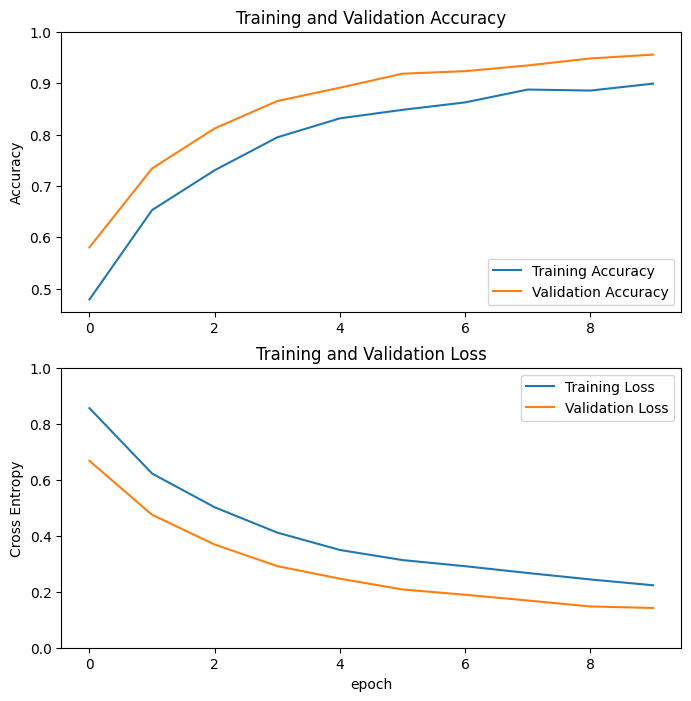

In [ ]:
# Create the base model from the pre-trained model MobileNet V2 adam learning_rate = 0.0001
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
base_model = tf.keras.Model(inputs, outputs)
base_learning_rate = 0.0001
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),#adam
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 10
loss0, accuracy0 = base_model.evaluate(validation_dataset)
history = base_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

(32, 5, 5, 1280)
(32, 1280)
(32, 1)
26/26 [==============================] - 3s 31ms/step - loss: 1.0193 - accuracy: 0.4183
Epoch 1/10
63/63 [==============================] - 8s 70ms/step - loss: 0.3977 - accuracy: 0.7950 - val_loss: 0.1239 - val_accuracy: 0.9616
Epoch 2/10
63/63 [==============================] - 4s 54ms/step - loss: 0.1933 - accuracy: 0.9155 - val_loss: 0.0865 - val_accuracy: 0.9740
Epoch 3/10
63/63 [==============================] - 4s 54ms/step - loss: 0.1572 - accuracy: 0.9340 - val_loss: 0.0733 - val_accuracy: 0.9765
Epoch 4/10
63/63 [==============================] - 4s 55ms/step - loss: 0.1470 - accuracy: 0.9315 - val_loss: 0.0672 - val_accuracy: 0.9790
Epoch 5/10
63/63 [==============================] - 4s 53ms/step - loss: 0.1244 - accuracy: 0.9460 - val_loss: 0.0572 - val_accuracy: 0.9827
Epoch 6/10
63/63 [==============================] - 5s 72ms/step - loss: 0.1269 - accuracy: 0.9465 - val_loss: 0.0554 - val_accuracy: 0.9827
Epoch 7/10
63/63 [============

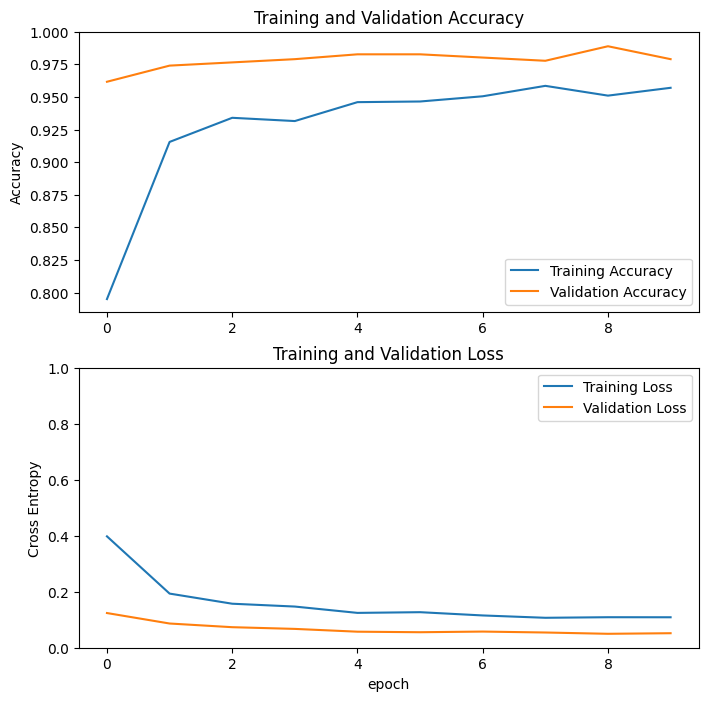

In [ ]:
# Create the base model from the pre-trained model MobileNet V2 adam learning_rate = 0.001
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
base_model = tf.keras.Model(inputs, outputs)
base_learning_rate = 0.001
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),#adam
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 10
loss0, accuracy0 = base_model.evaluate(validation_dataset)
history = base_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

(32, 5, 5, 1280)
(32, 1280)
(32, 1)
26/26 [==============================] - 3s 46ms/step - loss: 0.7409 - accuracy: 0.5285
Epoch 1/10
63/63 [==============================] - 7s 54ms/step - loss: 0.2270 - accuracy: 0.9070 - val_loss: 0.0748 - val_accuracy: 0.9641
Epoch 2/10
63/63 [==============================] - 4s 56ms/step - loss: 0.1539 - accuracy: 0.9410 - val_loss: 0.0623 - val_accuracy: 0.9715
Epoch 3/10
63/63 [==============================] - 4s 64ms/step - loss: 0.1827 - accuracy: 0.9410 - val_loss: 0.1112 - val_accuracy: 0.9653
Epoch 4/10
63/63 [==============================] - 4s 55ms/step - loss: 0.1551 - accuracy: 0.9435 - val_loss: 0.0541 - val_accuracy: 0.9802
Epoch 5/10
63/63 [==============================] - 4s 61ms/step - loss: 0.1653 - accuracy: 0.9460 - val_loss: 0.0742 - val_accuracy: 0.9765
Epoch 6/10
63/63 [==============================] - 4s 55ms/step - loss: 0.1484 - accuracy: 0.9520 - val_loss: 0.0554 - val_accuracy: 0.9839
Epoch 7/10
63/63 [============

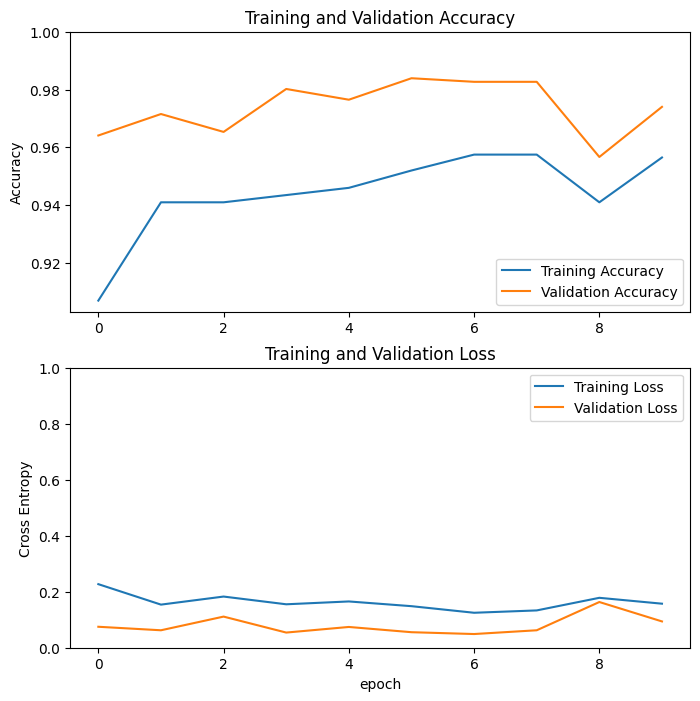

In [ ]:
# Create the base model from the pre-trained model MobileNet V2 adam learning_rate = 0.01
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
base_model = tf.keras.Model(inputs, outputs)
base_learning_rate = 0.01
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),#adam
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 10
loss0, accuracy0 = base_model.evaluate(validation_dataset)
history = base_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

(32, 5, 5, 1280)
(32, 1280)
(32, 1)
26/26 [==============================] - 3s 29ms/step - loss: 0.8108 - accuracy: 0.4926
Epoch 1/10
63/63 [==============================] - 7s 55ms/step - loss: 0.7864 - accuracy: 0.5370 - val_loss: 0.7442 - val_accuracy: 0.5532
Epoch 2/10
63/63 [==============================] - 5s 73ms/step - loss: 0.7448 - accuracy: 0.5540 - val_loss: 0.7157 - val_accuracy: 0.5631
Epoch 3/10
63/63 [==============================] - 4s 55ms/step - loss: 0.7218 - accuracy: 0.5835 - val_loss: 0.6943 - val_accuracy: 0.5891
Epoch 4/10
63/63 [==============================] - 4s 54ms/step - loss: 0.6961 - accuracy: 0.5950 - val_loss: 0.6745 - val_accuracy: 0.6015
Epoch 5/10
63/63 [==============================] - 5s 73ms/step - loss: 0.6956 - accuracy: 0.5975 - val_loss: 0.6578 - val_accuracy: 0.6126
Epoch 6/10
63/63 [==============================] - 4s 55ms/step - loss: 0.6945 - accuracy: 0.6010 - val_loss: 0.6480 - val_accuracy: 0.6225
Epoch 7/10
63/63 [============

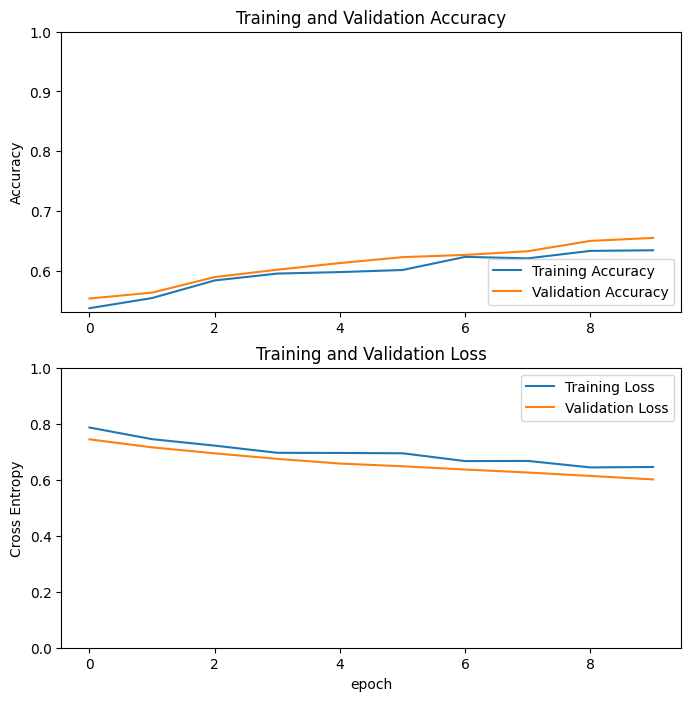

In [ ]:
# Create the base model from the pre-trained model MobileNet V2 adagrad learning_rate = 0.0001
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
base_model = tf.keras.Model(inputs, outputs)
base_learning_rate = 0.0001
base_model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=base_learning_rate),#adagrad
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 10
loss0, accuracy0 = base_model.evaluate(validation_dataset)
history = base_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

(32, 5, 5, 1280)
(32, 1280)
(32, 1)
26/26 [==============================] - 2s 31ms/step - loss: 0.8980 - accuracy: 0.4146
Epoch 1/10
63/63 [==============================] - 7s 68ms/step - loss: 0.6460 - accuracy: 0.6305 - val_loss: 0.4455 - val_accuracy: 0.7735
Epoch 2/10
63/63 [==============================] - 4s 53ms/step - loss: 0.4664 - accuracy: 0.7605 - val_loss: 0.3359 - val_accuracy: 0.8577
Epoch 3/10
63/63 [==============================] - 4s 53ms/step - loss: 0.3895 - accuracy: 0.8170 - val_loss: 0.2818 - val_accuracy: 0.8775
Epoch 4/10
63/63 [==============================] - 5s 77ms/step - loss: 0.3508 - accuracy: 0.8385 - val_loss: 0.2497 - val_accuracy: 0.8973
Epoch 5/10
63/63 [==============================] - 4s 54ms/step - loss: 0.3190 - accuracy: 0.8595 - val_loss: 0.2285 - val_accuracy: 0.9035
Epoch 6/10
63/63 [==============================] - 4s 54ms/step - loss: 0.3005 - accuracy: 0.8660 - val_loss: 0.2080 - val_accuracy: 0.9146
Epoch 7/10
63/63 [============

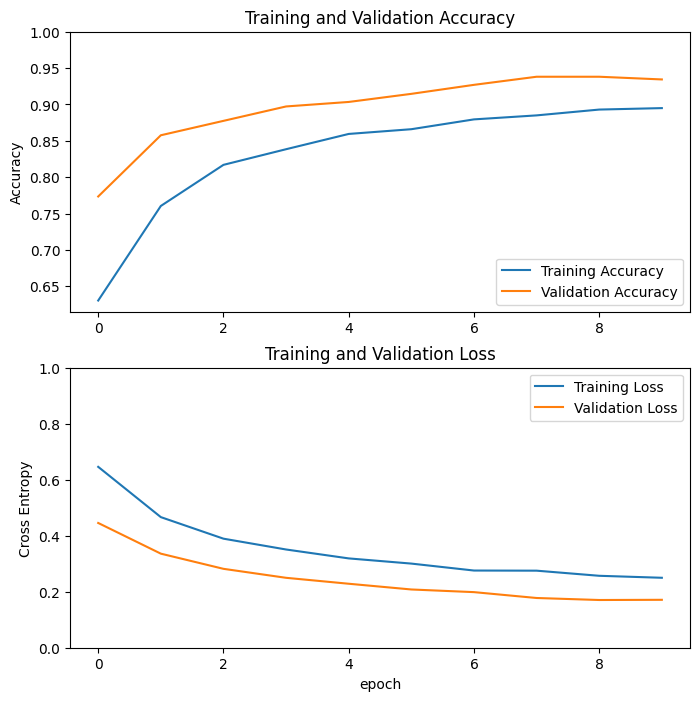

In [ ]:
# Create the base model from the pre-trained model MobileNet V2 adagrad learning_rate = 0.001
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
base_model = tf.keras.Model(inputs, outputs)
base_learning_rate = 0.001
base_model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=base_learning_rate),#adagrad
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 10
loss0, accuracy0 = base_model.evaluate(validation_dataset)
history = base_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

9406464/9406464 [==============================] - 1s 0us/step
(32, 5, 5, 1280)
(32, 1280)
(32, 1)
26/26 [==============================] - 4s 46ms/step - loss: 0.9498 - accuracy: 0.4022
Epoch 1/10
63/63 [==============================] - 9s 76ms/step - loss: 0.2987 - accuracy: 0.8640 - val_loss: 0.1019 - val_accuracy: 0.9653
Epoch 2/10
63/63 [==============================] - 4s 56ms/step - loss: 0.1781 - accuracy: 0.9220 - val_loss: 0.0791 - val_accuracy: 0.9715
Epoch 3/10
63/63 [==============================] - 4s 63ms/step - loss: 0.1513 - accuracy: 0.9375 - val_loss: 0.0697 - val_accuracy: 0.9752
Epoch 4/10
63/63 [==============================] - 5s 84ms/step - loss: 0.1479 - accuracy: 0.9350 - val_loss: 0.0685 - val_accuracy: 0.9740
Epoch 5/10
63/63 [==============================] - 4s 56ms/step - loss: 0.1325 - accuracy: 0.9390 - val_loss: 0.0622 - val_accuracy: 0.9790
Epoch 6/10
63/63 [==============================] - 4s 61ms/step - loss: 0.1302 - accuracy: 0.9435 - val_los

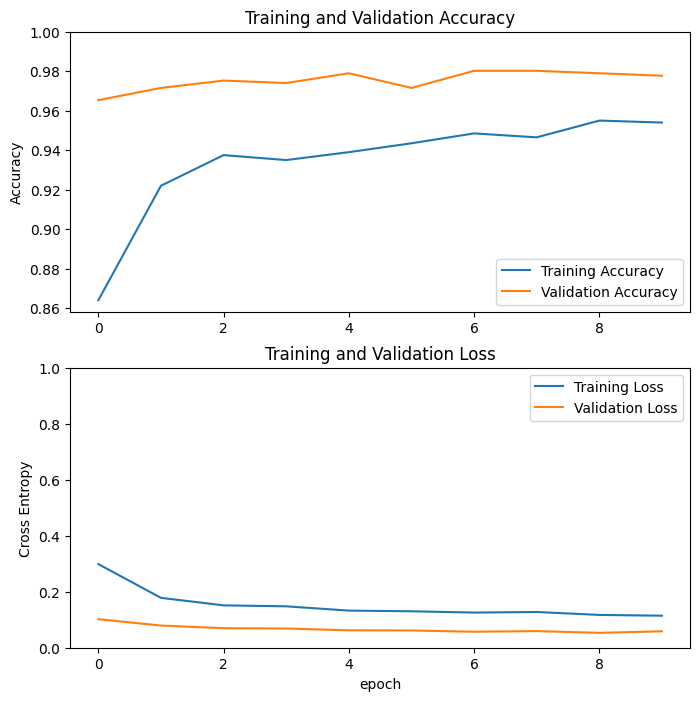

In [ ]:
# Create the base model from the pre-trained model MobileNet V2 adagrad learning_rate = 0.01
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
base_model = tf.keras.Model(inputs, outputs)
base_learning_rate = 0.01
base_model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=base_learning_rate),#adagrad
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 10
loss0, accuracy0 = base_model.evaluate(validation_dataset)
history = base_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

(32, 5, 5, 1280)
(32, 1280)
(32, 1)
26/26 [==============================] - 3s 33ms/step - loss: 0.8625 - accuracy: 0.5124
Epoch 1/10
63/63 [==============================] - 7s 56ms/step - loss: 0.9273 - accuracy: 0.4810 - val_loss: 0.7826 - val_accuracy: 0.5520
Epoch 2/10
63/63 [==============================] - 5s 84ms/step - loss: 0.8832 - accuracy: 0.5025 - val_loss: 0.7499 - val_accuracy: 0.5557
Epoch 3/10
63/63 [==============================] - 4s 67ms/step - loss: 0.8436 - accuracy: 0.5035 - val_loss: 0.7181 - val_accuracy: 0.5483
Epoch 4/10
63/63 [==============================] - 5s 70ms/step - loss: 0.8224 - accuracy: 0.5225 - val_loss: 0.6544 - val_accuracy: 0.5854
Epoch 5/10
63/63 [==============================] - 4s 59ms/step - loss: 0.7701 - accuracy: 0.5610 - val_loss: 0.6200 - val_accuracy: 0.6101
Epoch 6/10
63/63 [==============================] - 4s 55ms/step - loss: 0.7439 - accuracy: 0.5645 - val_loss: 0.6070 - val_accuracy: 0.6126
Epoch 7/10
63/63 [============

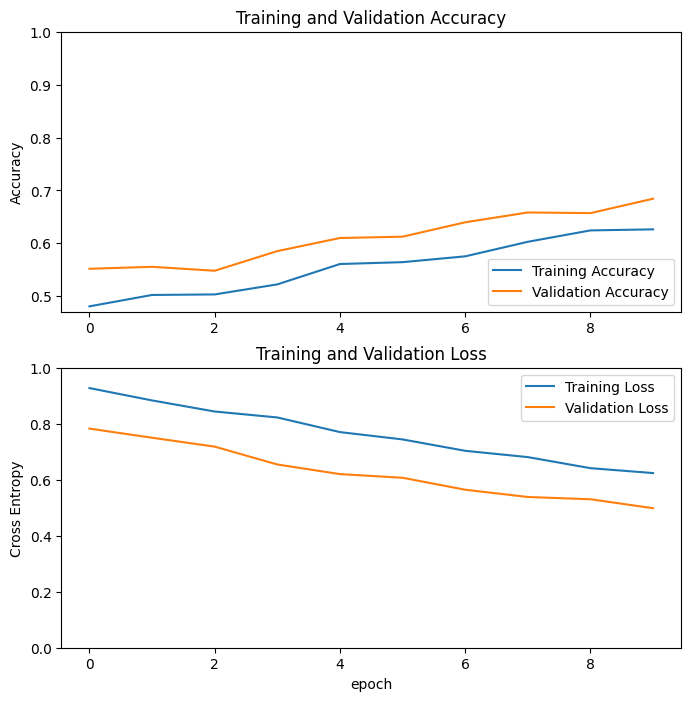

In [ ]:
# Create the base model from the pre-trained model MobileNet V2 SGD learning_rate = 0.0001
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
base_model = tf.keras.Model(inputs, outputs)
base_learning_rate = 0.0001
base_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),#SGD
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 10
loss0, accuracy0 = base_model.evaluate(validation_dataset)
history = base_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

(32, 5, 5, 1280)
(32, 1280)
(32, 1)
26/26 [==============================] - 3s 32ms/step - loss: 0.7404 - accuracy: 0.5384
Epoch 1/10
63/63 [==============================] - 8s 82ms/step - loss: 0.6259 - accuracy: 0.6410 - val_loss: 0.4792 - val_accuracy: 0.7587
Epoch 2/10
63/63 [==============================] - 4s 56ms/step - loss: 0.4677 - accuracy: 0.7670 - val_loss: 0.3629 - val_accuracy: 0.8255
Epoch 3/10
63/63 [==============================] - 5s 75ms/step - loss: 0.4012 - accuracy: 0.7925 - val_loss: 0.2839 - val_accuracy: 0.8800
Epoch 4/10
63/63 [==============================] - 4s 55ms/step - loss: 0.3289 - accuracy: 0.8445 - val_loss: 0.2484 - val_accuracy: 0.8936
Epoch 5/10
63/63 [==============================] - 5s 78ms/step - loss: 0.3029 - accuracy: 0.8580 - val_loss: 0.2149 - val_accuracy: 0.9059
Epoch 6/10
63/63 [==============================] - 4s 57ms/step - loss: 0.2953 - accuracy: 0.8585 - val_loss: 0.1991 - val_accuracy: 0.9134
Epoch 7/10
63/63 [============

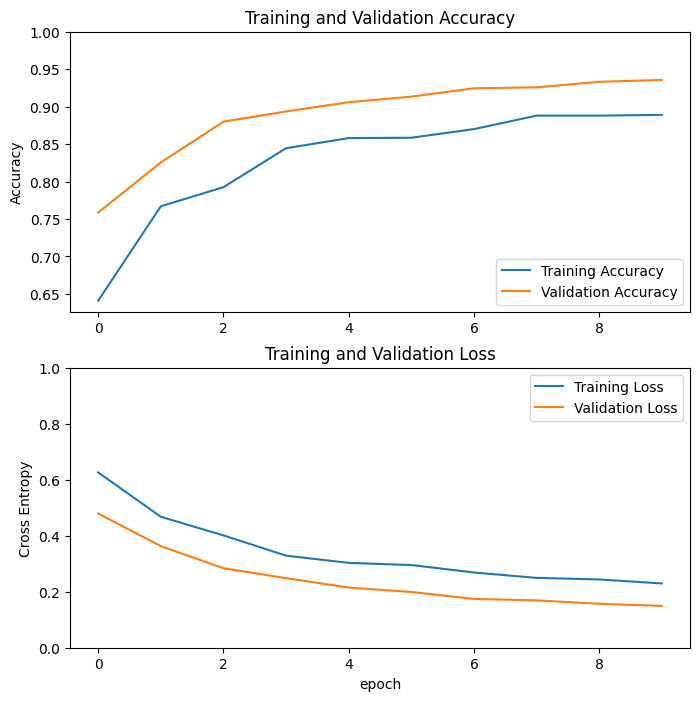

In [ ]:
# Create the base model from the pre-trained model MobileNet V2 SGD learning_rate = 0.001
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
base_model = tf.keras.Model(inputs, outputs)
base_learning_rate = 0.001
base_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),#SGD
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 10
loss0, accuracy0 = base_model.evaluate(validation_dataset)
history = base_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

(32, 5, 5, 1280)
(32, 1280)
(32, 1)
26/26 [==============================] - 3s 44ms/step - loss: 0.7867 - accuracy: 0.4926
Epoch 1/10
63/63 [==============================] - 7s 56ms/step - loss: 0.3513 - accuracy: 0.8260 - val_loss: 0.1486 - val_accuracy: 0.9406
Epoch 2/10
63/63 [==============================] - 4s 56ms/step - loss: 0.2028 - accuracy: 0.9145 - val_loss: 0.1152 - val_accuracy: 0.9554
Epoch 3/10
63/63 [==============================] - 5s 74ms/step - loss: 0.1684 - accuracy: 0.9245 - val_loss: 0.0908 - val_accuracy: 0.9703
Epoch 4/10
63/63 [==============================] - 4s 55ms/step - loss: 0.1486 - accuracy: 0.9365 - val_loss: 0.0808 - val_accuracy: 0.9765
Epoch 5/10
63/63 [==============================] - 4s 62ms/step - loss: 0.1560 - accuracy: 0.9280 - val_loss: 0.0766 - val_accuracy: 0.9752
Epoch 6/10
63/63 [==============================] - 4s 57ms/step - loss: 0.1402 - accuracy: 0.9405 - val_loss: 0.0699 - val_accuracy: 0.9777
Epoch 7/10
63/63 [============

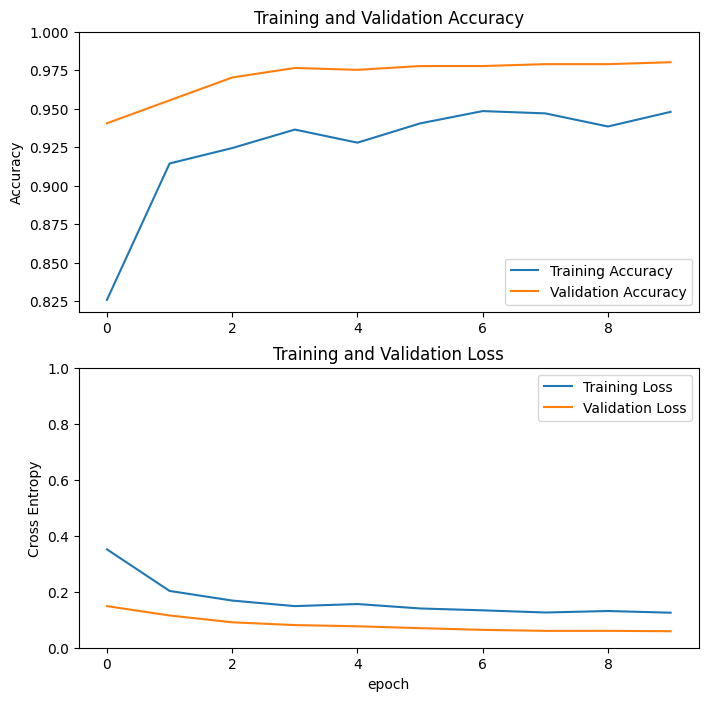

In [ ]:
# Create the base model from the pre-trained model MobileNet V2 SGD learning_rate = 0.01
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
base_model = tf.keras.Model(inputs, outputs)
base_learning_rate = 0.01
base_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),#SGD
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 10
loss0, accuracy0 = base_model.evaluate(validation_dataset)
history = base_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

(32, 5, 5, 1280)
(32, 1280)
(32, 1)
26/26 [==============================] - 3s 32ms/step - loss: 0.7828 - accuracy: 0.5408
Epoch 1/10
63/63 [==============================] - 7s 56ms/step - loss: 0.6801 - accuracy: 0.6265 - val_loss: 0.5070 - val_accuracy: 0.6696
Epoch 2/10
63/63 [==============================] - 5s 75ms/step - loss: 0.4967 - accuracy: 0.7270 - val_loss: 0.3658 - val_accuracy: 0.7834
Epoch 3/10
63/63 [==============================] - 4s 56ms/step - loss: 0.3960 - accuracy: 0.8045 - val_loss: 0.2778 - val_accuracy: 0.8639
Epoch 4/10
63/63 [==============================] - 4s 55ms/step - loss: 0.3272 - accuracy: 0.8500 - val_loss: 0.2278 - val_accuracy: 0.8936
Epoch 5/10
63/63 [==============================] - 5s 73ms/step - loss: 0.2860 - accuracy: 0.8660 - val_loss: 0.1821 - val_accuracy: 0.9208
Epoch 6/10
63/63 [==============================] - 4s 55ms/step - loss: 0.2595 - accuracy: 0.8815 - val_loss: 0.1755 - val_accuracy: 0.9196
Epoch 7/10
63/63 [============

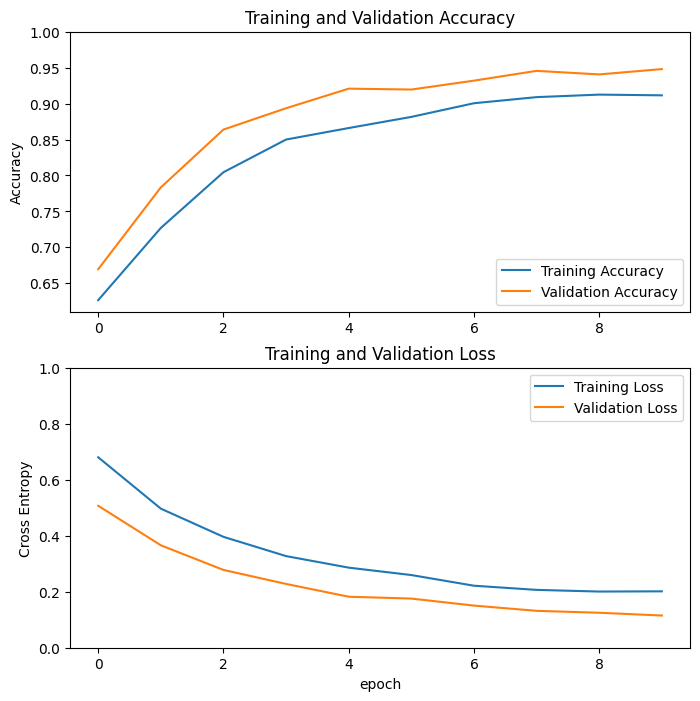

In [ ]:
# Create the base model from the pre-trained model MobileNet V2 #RMSprop learning_rate = 0.0001
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
base_model = tf.keras.Model(inputs, outputs)
base_learning_rate = 0.0001
base_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),#RMSprop
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 10
loss0, accuracy0 = base_model.evaluate(validation_dataset)
history = base_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

(32, 5, 5, 1280)
(32, 1280)
(32, 1)
26/26 [==============================] - 3s 33ms/step - loss: 0.6529 - accuracy: 0.5817
Epoch 1/10
63/63 [==============================] - 7s 56ms/step - loss: 0.2987 - accuracy: 0.8560 - val_loss: 0.0977 - val_accuracy: 0.9691
Epoch 2/10
63/63 [==============================] - 5s 65ms/step - loss: 0.1722 - accuracy: 0.9255 - val_loss: 0.0653 - val_accuracy: 0.9740
Epoch 3/10
63/63 [==============================] - 4s 68ms/step - loss: 0.1372 - accuracy: 0.9450 - val_loss: 0.0622 - val_accuracy: 0.9728
Epoch 4/10
63/63 [==============================] - 5s 78ms/step - loss: 0.1319 - accuracy: 0.9410 - val_loss: 0.0610 - val_accuracy: 0.9802
Epoch 5/10
63/63 [==============================] - 4s 54ms/step - loss: 0.1217 - accuracy: 0.9440 - val_loss: 0.0492 - val_accuracy: 0.9765
Epoch 6/10
63/63 [==============================] - 4s 56ms/step - loss: 0.1341 - accuracy: 0.9445 - val_loss: 0.0562 - val_accuracy: 0.9752
Epoch 7/10
63/63 [============

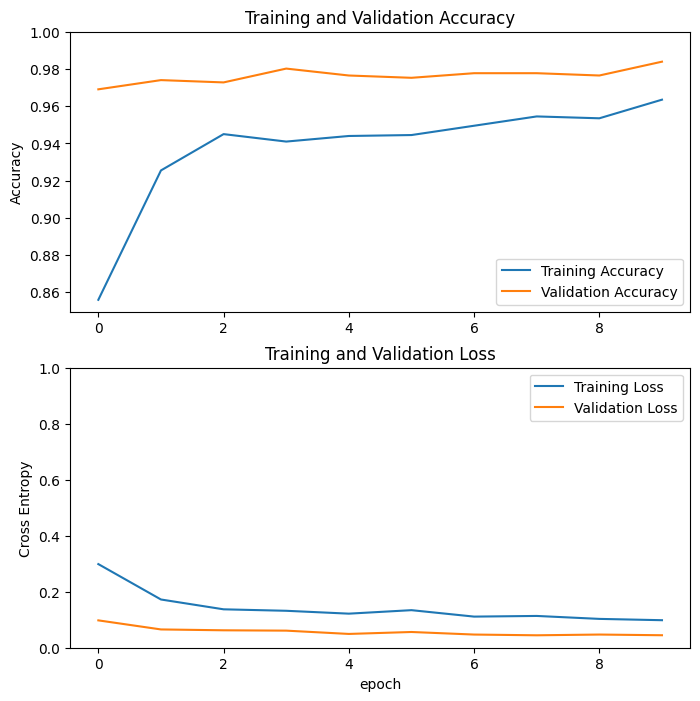

In [ ]:
# Create the base model from the pre-trained model MobileNet V2 #RMSprop learning_rate = 0.001
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
base_model = tf.keras.Model(inputs, outputs)
base_learning_rate = 0.001
base_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),#RMSprop
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 10
loss0, accuracy0 = base_model.evaluate(validation_dataset)
history = base_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

(32, 5, 5, 1280)
(32, 1280)
(32, 1)
26/26 [==============================] - 3s 33ms/step - loss: 0.7725 - accuracy: 0.5681
Epoch 1/10
63/63 [==============================] - 8s 74ms/step - loss: 0.3820 - accuracy: 0.8775 - val_loss: 0.0538 - val_accuracy: 0.9777
Epoch 2/10
63/63 [==============================] - 4s 56ms/step - loss: 0.2060 - accuracy: 0.9385 - val_loss: 0.0616 - val_accuracy: 0.9765
Epoch 3/10
63/63 [==============================] - 4s 56ms/step - loss: 0.2249 - accuracy: 0.9415 - val_loss: 0.0595 - val_accuracy: 0.9752
Epoch 4/10
63/63 [==============================] - 5s 73ms/step - loss: 0.1939 - accuracy: 0.9470 - val_loss: 0.0645 - val_accuracy: 0.9740
Epoch 5/10
63/63 [==============================] - 4s 55ms/step - loss: 0.1804 - accuracy: 0.9445 - val_loss: 0.0659 - val_accuracy: 0.9790
Epoch 6/10
63/63 [==============================] - 4s 58ms/step - loss: 0.1904 - accuracy: 0.9400 - val_loss: 0.0725 - val_accuracy: 0.9790
Epoch 7/10
63/63 [============

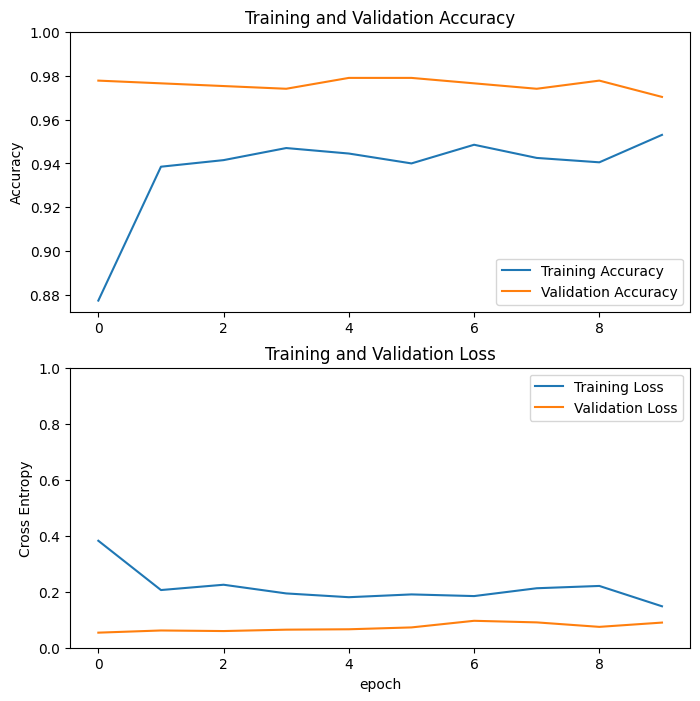

In [ ]:
# Create the base model from the pre-trained model MobileNet V2 #RMSprop learning_rate = 0.01
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
base_model = tf.keras.Model(inputs, outputs)
base_learning_rate = 0.01
base_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),#RMSprop
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 10
loss0, accuracy0 = base_model.evaluate(validation_dataset)
history = base_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  8


Epoch 10/20
63/63 [==============================] - 10s 108ms/step - loss: 0.2053 - accuracy: 0.9450 - val_loss: 0.1098 - val_accuracy: 0.9666
Epoch 11/20
63/63 [==============================] - 6s 80ms/step - loss: 0.1946 - accuracy: 0.9405 - val_loss: 0.0756 - val_accuracy: 0.9703
Epoch 12/20
63/63 [==============================] - 4s 55ms/step - loss: 0.1435 - accuracy: 0.9500 - val_loss: 0.0902 - val_accuracy: 0.9666
Epoch 13/20
63/63 [==============================] - 5s 74ms/step - loss: 0.1597 - accuracy: 0.9445 - val_loss: 0.1009 - val_accuracy: 0.9666
Epoch 14/20
63/63 [==============================] - 4s 56ms/step - loss: 0.1669 - accuracy: 0.9405 - val_loss: 0.0984 - val_accuracy: 0.9691
Epoch 15/20
63/63 [==============================] - 4s 57ms/step - loss: 0.1708 - accuracy: 0.9525 - val_loss: 0.0957 - val_accuracy: 0.9678
Epoch 16/20
63/63 [==============================] - 4s 60ms/step - loss: 0.1569 - accuracy: 0.9485 - val_loss: 0.0848 - val_accuracy: 0.9703
Epoc

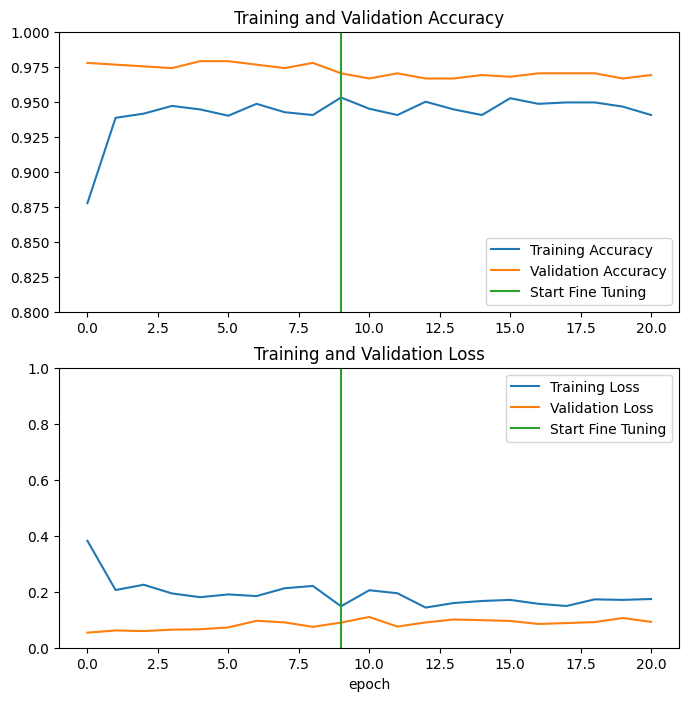

In [ ]:
base_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001/10),
              metrics=['accuracy'])
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = base_model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Epoch 10/20
63/63 [==============================] - 7s 67ms/step - loss: 0.1905 - accuracy: 0.9415 - val_loss: 0.0906 - val_accuracy: 0.9678
Epoch 11/20
63/63 [==============================] - 5s 78ms/step - loss: 0.1918 - accuracy: 0.9460 - val_loss: 0.1021 - val_accuracy: 0.9691
Epoch 12/20
63/63 [==============================] - 4s 54ms/step - loss: 0.1749 - accuracy: 0.9430 - val_loss: 0.0921 - val_accuracy: 0.9703
Epoch 13/20
63/63 [==============================] - 4s 56ms/step - loss: 0.1537 - accuracy: 0.9515 - val_loss: 0.0844 - val_accuracy: 0.9678
Epoch 14/20
63/63 [==============================] - 5s 72ms/step - loss: 0.1905 - accuracy: 0.9465 - val_loss: 0.1115 - val_accuracy: 0.9653
Epoch 15/20
63/63 [==============================] - 4s 57ms/step - loss: 0.1603 - accuracy: 0.9450 - val_loss: 0.0939 - val_accuracy: 0.9666
Epoch 16/20
63/63 [==============================] - 4s 55ms/step - loss: 0.1465 - accuracy: 0.9545 - val_loss: 0.0837 - val_accuracy: 0.9691
Epoch 

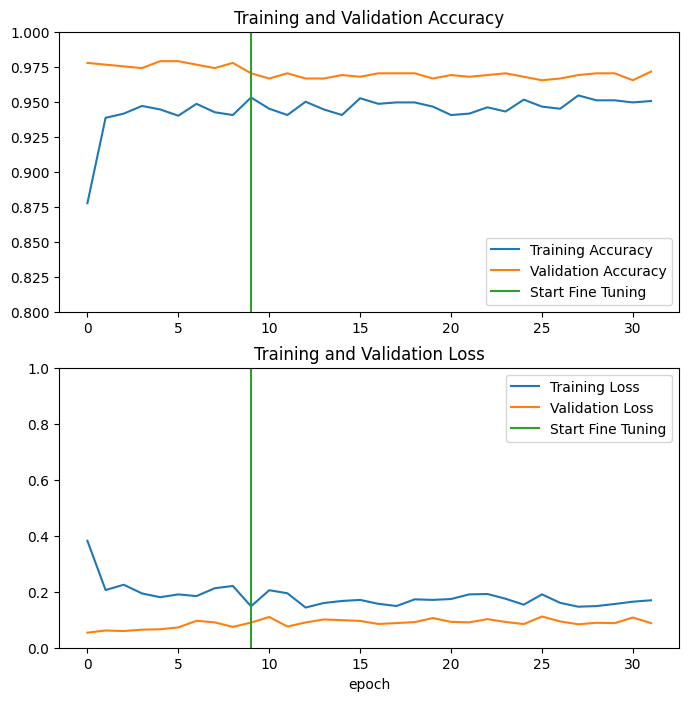

In [ ]:
base_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001/10),
              metrics=['accuracy'])
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = base_model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Epoch 10/20
63/63 [==============================] - 7s 68ms/step - loss: 0.1905 - accuracy: 0.9415 - val_loss: 0.0809 - val_accuracy: 0.9691
Epoch 11/20
63/63 [==============================] - 5s 71ms/step - loss: 0.1833 - accuracy: 0.9420 - val_loss: 0.0957 - val_accuracy: 0.9691
Epoch 12/20
63/63 [==============================] - 4s 55ms/step - loss: 0.1791 - accuracy: 0.9450 - val_loss: 0.1070 - val_accuracy: 0.9666
Epoch 13/20
63/63 [==============================] - 4s 56ms/step - loss: 0.1389 - accuracy: 0.9540 - val_loss: 0.1018 - val_accuracy: 0.9666
Epoch 14/20
63/63 [==============================] - 4s 60ms/step - loss: 0.1762 - accuracy: 0.9470 - val_loss: 0.0998 - val_accuracy: 0.9691
Epoch 15/20
63/63 [==============================] - 4s 55ms/step - loss: 0.1466 - accuracy: 0.9475 - val_loss: 0.1060 - val_accuracy: 0.9666
Epoch 16/20
63/63 [==============================] - 4s 56ms/step - loss: 0.1554 - accuracy: 0.9550 - val_loss: 0.0923 - val_accuracy: 0.9703
Epoch 

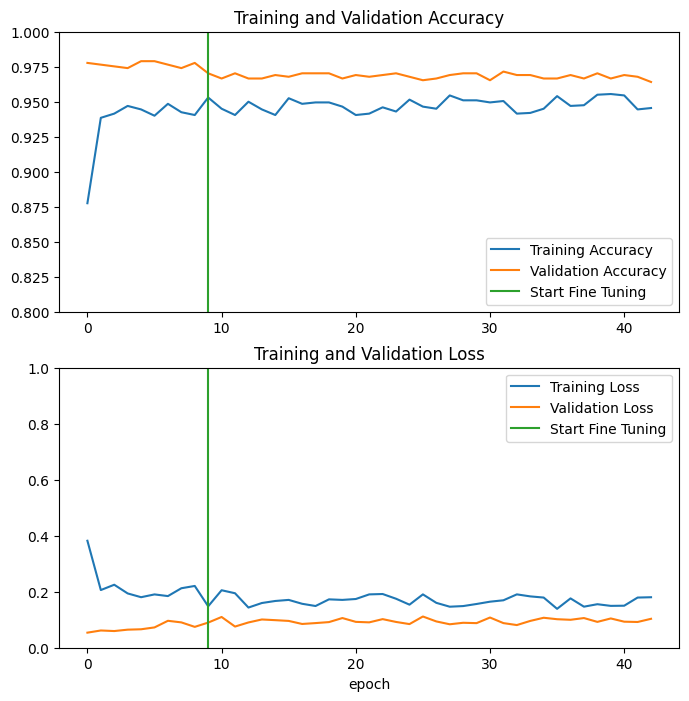

In [ ]:
base_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01/10),
              metrics=['accuracy'])
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = base_model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()